In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss_L1 = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.hidden = h
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss_L1(self, size_average=True):
        loss = torch.abs(self.hidden)
        if size_average:
            self._loss_L1 = loss.mean()
        else:
            self._loss_L1 = loss.sum()
        return self._loss_L1
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [6]:
models = {'16': Net(16).to(device), '32': Net(32).to(device), '64': Net(64).to(device)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss_L1 = model.loss_L1()
            loss = model.loss(output, data) + loss_L1
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._loss_L1))
        print(line + losses)

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
L1_lambda = lambda p: 'L1 loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + L1_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    loss_L1 = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                loss_L1[k] += m.loss_L1(size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        loss_L1[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], loss_L1[k]))
    
    lines = '\n'.join([line(k, test_loss[k], loss_L1[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [9]:
for epoch in range(1, 51):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.990663 32: 0.990356 64: 0.994175
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.898218 32: 0.812595 64: 0.516871
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.810094 32: 0.504730 64: 0.363947
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.622472 32: 0.414662 64: 0.331218
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.502171 32: 0.364776 64: 0.302576
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.431986 32: 0.331773 64: 0.276365
Test set:
16: loss: 0.4501	L1 loss: 0.2347
32: loss: 0.3500	L1 loss: 0.2212
64: loss: 0.2945	L1 loss: 0.1914

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.454098 32: 0.357892 64: 0.300651
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.408254 32: 0.328287 64: 0.275178
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.390523 32: 0.323017 64: 0.263943
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.391309 32: 0.328367 64: 0.268824
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.354266 32: 0.299376 64: 0.250249
Train Ep

Test set:
16: loss: 0.2038	L1 loss: 0.0589
32: loss: 0.1468	L1 loss: 0.0697
64: loss: 0.0923	L1 loss: 0.0722

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.188170 32: 0.138411 64: 0.087142
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.204066 32: 0.142999 64: 0.090075
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.198163 32: 0.142505 64: 0.090412
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.197541 32: 0.140911 64: 0.087927
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.210162 32: 0.148848 64: 0.094643
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.184921 32: 0.131648 64: 0.081132
Test set:
16: loss: 0.1990	L1 loss: 0.0566
32: loss: 0.1410	L1 loss: 0.0686
64: loss: 0.0877	L1 loss: 0.0712

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.188854 32: 0.134161 64: 0.081893
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.187248 32: 0.129645 64: 0.078870
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.203224 32: 0.138910 64: 0.084114
Train Epoch: 16 [30000/50000 (60%)]	Losses 16: 0.18

Train Epoch: 28 [40000/50000 (80%)]	Losses 16: 0.166486 32: 0.103495 64: 0.061435
Train Epoch: 28 [50000/50000 (100%)]	Losses 16: 0.158795 32: 0.099997 64: 0.057650
Test set:
16: loss: 0.1558	L1 loss: 0.0530
32: loss: 0.0950	L1 loss: 0.0635
64: loss: 0.0549	L1 loss: 0.0593

Train Epoch: 29 [0/50000 (0%)]	Losses 16: 0.149389 32: 0.092594 64: 0.052901
Train Epoch: 29 [10000/50000 (20%)]	Losses 16: 0.157308 32: 0.096771 64: 0.055405
Train Epoch: 29 [20000/50000 (40%)]	Losses 16: 0.151813 32: 0.093685 64: 0.053879
Train Epoch: 29 [30000/50000 (60%)]	Losses 16: 0.149597 32: 0.087806 64: 0.050314
Train Epoch: 29 [40000/50000 (80%)]	Losses 16: 0.153195 32: 0.096021 64: 0.054363
Train Epoch: 29 [50000/50000 (100%)]	Losses 16: 0.149584 32: 0.091060 64: 0.052634
Test set:
16: loss: 0.1533	L1 loss: 0.0538
32: loss: 0.0931	L1 loss: 0.0634
64: loss: 0.0534	L1 loss: 0.0587

Train Epoch: 30 [0/50000 (0%)]	Losses 16: 0.155180 32: 0.093012 64: 0.052744
Train Epoch: 30 [10000/50000 (20%)]	Losses 16: 0.1

Train Epoch: 42 [20000/50000 (40%)]	Losses 16: 0.129721 32: 0.070784 64: 0.037381
Train Epoch: 42 [30000/50000 (60%)]	Losses 16: 0.131302 32: 0.077802 64: 0.044760
Train Epoch: 42 [40000/50000 (80%)]	Losses 16: 0.128403 32: 0.072671 64: 0.038948
Train Epoch: 42 [50000/50000 (100%)]	Losses 16: 0.132179 32: 0.076851 64: 0.042488
Test set:
16: loss: 0.1289	L1 loss: 0.0538
32: loss: 0.0752	L1 loss: 0.0575
64: loss: 0.0412	L1 loss: 0.0512

Train Epoch: 43 [0/50000 (0%)]	Losses 16: 0.127580 32: 0.076725 64: 0.041363
Train Epoch: 43 [10000/50000 (20%)]	Losses 16: 0.132568 32: 0.075853 64: 0.041410
Train Epoch: 43 [20000/50000 (40%)]	Losses 16: 0.128237 32: 0.074520 64: 0.039775
Train Epoch: 43 [30000/50000 (60%)]	Losses 16: 0.120957 32: 0.068280 64: 0.036853
Train Epoch: 43 [40000/50000 (80%)]	Losses 16: 0.130347 32: 0.074930 64: 0.040013
Train Epoch: 43 [50000/50000 (100%)]	Losses 16: 0.115719 32: 0.065845 64: 0.034953
Test set:
16: loss: 0.1280	L1 loss: 0.0540
32: loss: 0.0742	L1 loss: 0.05

In [15]:
data, _ = next(iter(test_loader))
data = data.to(device)

output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()

with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((torch.abs(encoded) > 0.15).sum(1))
    encoded[torch.abs(encoded) < 0.15] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

eye_decoded = models['64'].decode(torch.eye(64).to(device))
eye_to_plot = ((eye_decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

minus_eye_decoded = models['64'].decode(-1.0 * torch.eye(64).to(device))
minus_eye_to_plot = ((minus_eye_decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()



tensor([ 2,  3,  3,  2,  2,  3,  2,  4,  4,  3,  6,  4,  3,  4,
         1,  2,  2,  4,  7,  2,  3,  2,  3,  1,  2,  5,  2,  3,
         4,  3,  4,  3,  4,  2,  3,  4,  4,  2,  3,  1,  2,  2,
         2,  2,  4,  3,  4,  1,  3,  2], device='cuda:6')


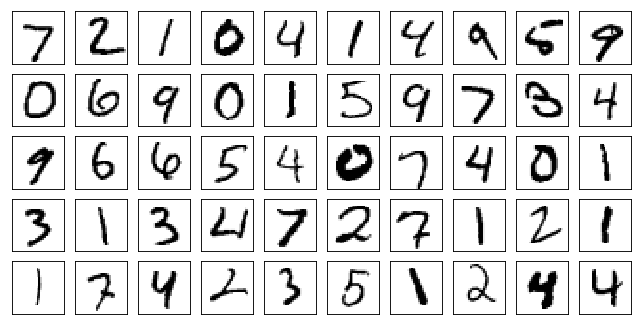

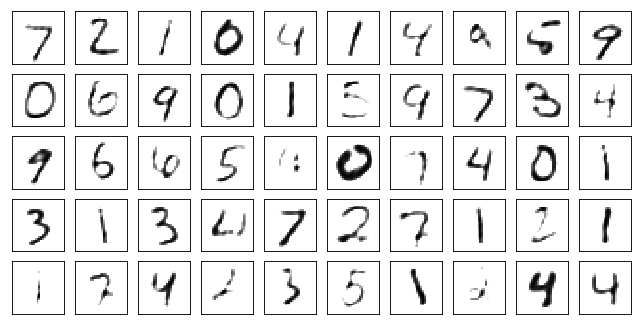

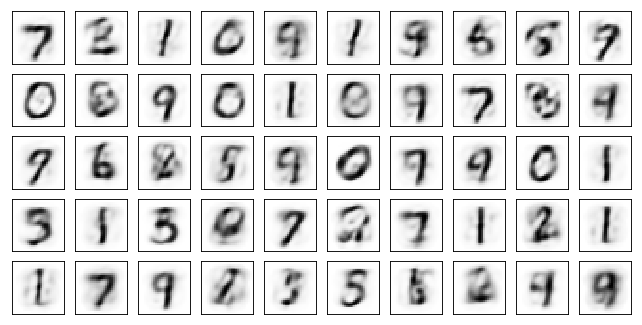

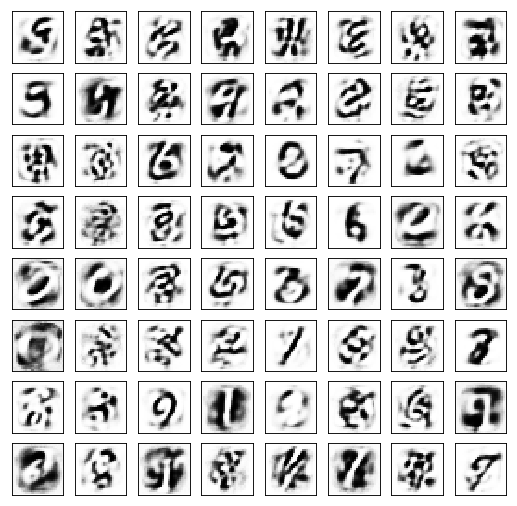

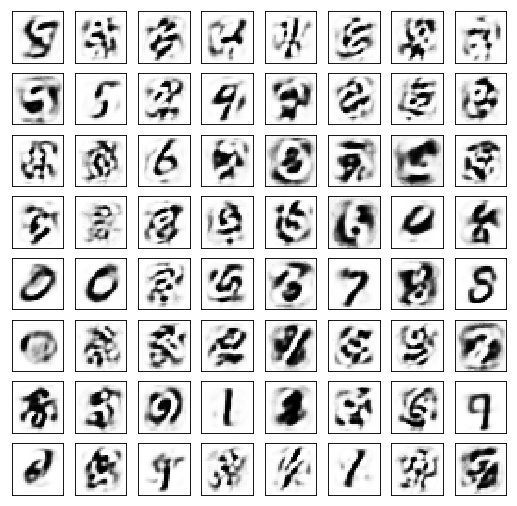

In [16]:
plot_mnist(data.data.cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(eye_to_plot, (8, 8))
plot_mnist(minus_eye_to_plot, (8, 8))